# TIF345/FYM345: Project 3: A Galton board on a rocking ship

# Names 
Jonatan Haraldsson [jonhara@chalmers.se](mailto:jonhara@chalmers.se)

Jesper Noord [noord@chalmers.se](mailto:noord@chalmers.se)

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import scipy 
import sklearn
import pandas as pd
import emcee
import numpy as np
import random
import tqdm
from tqdm import trange
import keras as keras
import tensorflow as tf

# LaTeX font
plt.style.use('default')
plt.rc('text', usetex = True)
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'serif'
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'
font_size = 16
plt.rcParams['font.size'] = font_size
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.top'] = True
plt.rcParams['ytick.right'] = True

sns.set_palette('deep')
from matplotlib import cbook, cm
from seaborn import cm
from matplotlib.colors import LightSource
# plot in separate window
%matplotlib inline

rng = np.random.default_rng(seed = 42)

### Importing and massaging data

In [2]:
board_data = np.load('board_data.npy')

board_df = pd.DataFrame(board_data, columns = [f'bin_{i}' for i in range(32)])

display(board_df)


,bin_0,bin_1,bin_2,bin_3,bin_4,bin_5,bin_6,bin_7,bin_8,bin_9,...,bin_22,bin_23,bin_24,bin_25,bin_26,bin_27,bin_28,bin_29,bin_30,bin_31
0,0.0,0.0,0.0,2.0,5.0,9.0,11.0,28.0,31.0,47.0,...,8.0,8.0,4.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,5.0,...,78.0,59.0,57.0,34.0,26.0,7.0,6.0,2.0,1.0,0.0
2,0.0,0.0,0.0,1.0,4.0,8.0,19.0,18.0,27.0,47.0,...,11.0,5.0,2.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0
3,1.0,8.0,13.0,57.0,79.0,85.0,116.0,109.0,119.0,118.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,2.0,1.0,...,88.0,54.0,70.0,28.0,25.0,14.0,8.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0,...,76.0,75.0,54.0,36.0,26.0,11.0,2.0,3.0,0.0,0.0
9996,2.0,47.0,60.0,107.0,113.0,109.0,121.0,117.0,100.0,72.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9997,9.0,29.0,63.0,81.0,115.0,121.0,131.0,112.0,99.0,78.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,115.0,99.0,87.0,85.0,84.0,48.0,30.0,12.0,3.0,0.0


### Plots

Referring to the classical case with a Galton board, where the bead has an equal probability of bouncing to the left or the right, the distribution will converge to a binomial distribution for $N_\text{samples} \rightarrow\infty$.

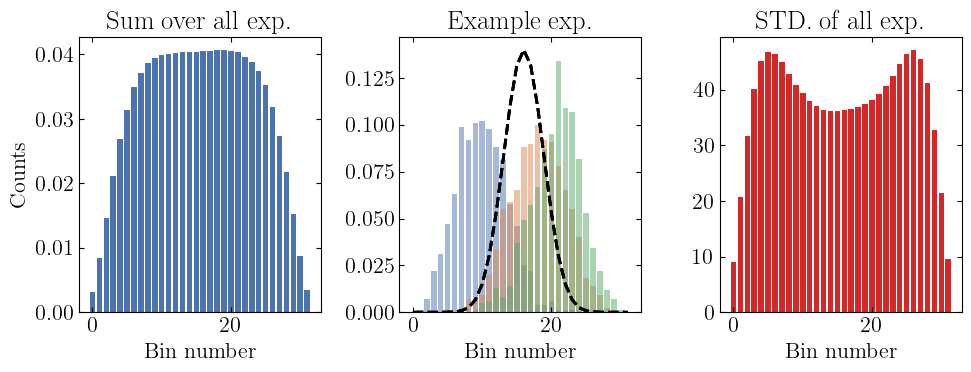

In [3]:

fig, ax = plt.subplots(1,3,figsize = (10, 4))

ax[0].bar(np.arange(32), board_data.sum(axis=0) / board_data.sum())
ax[0].set_xlabel('Bin number')
ax[0].set_ylabel('Counts')


for n in range(3):
    i = rng.integers(0, board_data.shape[0])
    ax[1].bar(np.arange(32), board_data[i]/ board_data[i].sum(),alpha=0.5)
    ax[1].plot(scipy.stats.binom.pmf(np.arange(32), n=32, p=1/2), color='black', lw=2,ls = '--')

ax[1].set_xlabel('Bin number')
ax[1].set_title('Example exp.')
ax[0].set_title('Sum over all exp.')
ax[2].set_title('STD. of all exp.')
ax[2].bar(np.arange(32), np.std(board_data,axis=0),color='tab:red')
ax[2].set_xlabel('Bin number')
plt.tight_layout()

plt.show()

In [4]:
def p_peg(alpha,s,left=None):
    if left == None:
        M = 0.
    elif left:
        M = 0.5
    else:
        M = -0.5
    return 0.5 + (alpha * M + s)
    
def simulator_slow(alpha,s, N=int(1e3)):
    rng = np.random.default_rng()
    bin_counts = np.zeros(32)
    for j in range(int(N)):
        left_bounces = 0
        left = 0
        left_ = 0
        for i in range(32):
            r = rng.uniform(0,1)
            if i == 0:
                left_ = r < p_peg(alpha,s,left=None)
            else:
                left_ = r < p_peg(alpha,s,left=left)
            if left_:
                left_bounces += 1
            else:
                pass
            left = left_
        bin_counts[left_bounces] += 1
        left_bounces = 0
    return bin_counts 

def p_peg_vec(alpha,s,left):
    M = np.zeros_like(left)
    M[left == True] = 0.5
    M[left == False] = -0.5
    p = 0.5 + (alpha * M + s)
    return p
    
def simulator(alpha,s, N=int(1e3)):
    rng = np.random.default_rng()
    bin_counts = np.zeros(32)
    left_bounces = np.zeros(32)
    left_ = np.zeros((N,32))

    r = rng.uniform(0,1,N)

    left_[:,0] = r < (0.5 + s)
    for i in range(1, 31):
        r = rng.uniform(0,1,N)
        left_[:,i] = r < p_peg_vec(alpha,s,left=left_[:,i-1])
        
    left_bounces = np.sum(left_, axis=1)

    for bounces in left_bounces:
        bin_counts[int(bounces)] += 1
    return bin_counts

In [5]:
def statistic(data):
    x = np.arange(len(data))
    data = data / np.sum(data)
    exp_val = np.sum(data * x) 
    var = np.sum(data * (x - exp_val)**2)
    return exp_val, var

(np.float64(25.57555), np.float64(10.0772921975))


<BarContainer object of 32 artists>

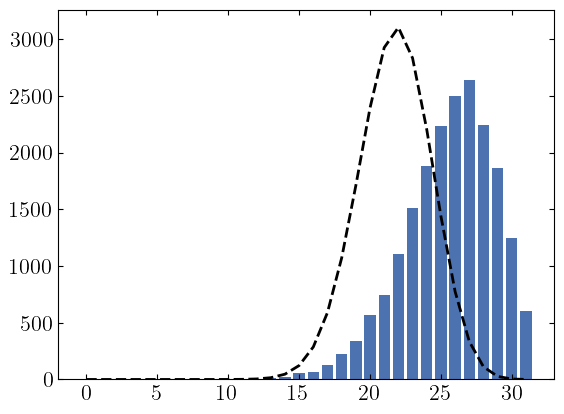

In [6]:
alpha = 0.4
s = 0.2
res = simulator(alpha,s, N=int(2e4))

print(statistic(res))

plt.plot(scipy.stats.binom.pmf(np.arange(32), n=31, p=p_peg(alpha, s)) * 2e4, color='black', lw=2,ls = '--')
plt.bar(np.arange(32), res)

In [7]:
alphas = np.linspace(0,0.5,11)
ss = np.linspace(-0.25,0.25,11)
means = np.zeros((len(alphas), len(ss)))
variances = np.zeros((len(alphas), len(ss)))
for i, alpha in enumerate(alphas):
    for j, s in enumerate(ss):
        res = simulator(alpha,s)
        mean, var = statistic(res)
        means[i,j] = mean
        variances[i,j] = var

In [8]:
def grid_gen(xlim, ylim, size=50):
    x = np.linspace(xlim[0], xlim[1], size)
    y = np.linspace(ylim[0], ylim[1], size)
    X, Y = np.meshgrid(x, y)
    return X, Y


def contour_generator(xlim, ylim, size=50):
    X, Y = grid_gen(xlim, ylim, size)
    Z1 = np.zeros_like(X)
    Z2 = np.zeros_like(X)

    for i in trange(X.shape[0]):
        for j in range(X.shape[1]):
            res = simulator(X[i, j], Y[i, j])
            mean, var = statistic(res)
            Z1[i, j] = mean
            Z2[i, j] = var
    return X, Y, Z1, Z2

In [9]:
def generate_data(N_samples):
    train_data = np.zeros((N_samples,32))
    target_data = np.zeros((N_samples,2))
    for n in trange(N_samples):
        s = np.random.uniform(-0.25,0.25)
        a = np.random.uniform(0,0.5)
        a = 0.0
        train_data[n,:] = simulator(a,s)
        target_data[n,0] = a
        target_data[n,1] = s
    return train_data, target_data
    

def generate_data_mesh(N_samples):
    train_data = np.zeros((N_samples**2,32))
    target_data = np.zeros((N_samples**2,2))
    s = np.random.uniform(-0.25,0.25,N_samples)
    a = np.random.uniform(0,0.5,N_samples)
    A,S = np.meshgrid(a,s)
    A = A.ravel()
    S = S.ravel()
    for n in trange(N_samples**2):
        train_data[n,:] = simulator(A[n],S[n])
        target_data[n,0] = A[n]
        target_data[n,1] = S[n]
    return train_data, target_data


# train_data, target_data = generate_data(50000)
#np.save('train_data_mesh.npy', train_data)
#np.save('target_data_mesh.npy', target_data)

In [10]:
# data = np.load('train_data_mesh.npy')
# target = np.load('target_data_mesh.npy')

In [11]:
def kernel(y_pred, y_obs):
    sq = []
    D = []
    h = 5
    for i in range(len(y_pred)):
        diff = (statistic(y_pred[i,:].ravel())[0] - statistic(y_obs.ravel())[0]) / h
        sq.append(diff**2)
        D.append(diff)
    SQ = np.array(sq)
    return D, np.exp(-0.5 * (SQ)) / np.sum(np.exp(-0.5 * (SQ)))

In [12]:
def shaper(X):
    return X.reshape(int(np.sqrt(len(X))),int(np.sqrt(len(X))))

def kernel_pred(y_obs,N=100,h=1, mode = None):
    sq = []
    D = []
    #s = np.random.uniform(-0.25,0.25,int(np.sqrt(N)))
    #a = np.random.uniform(0,0.5,int(np.sqrt(N)))
    a = np.linspace(0,0.5,int(np.sqrt(N)))
    s = np.linspace(-0.25,0.25,int(np.sqrt(N)))
    A,S = np.meshgrid(a,s)
    A = A.ravel()
    S = S.ravel()
    for i in trange((N)):
        if mode == 'mean':
            diff = statistic(simulator(alpha =A[i], s =S[i]).ravel())[0] - statistic(y_obs.ravel())[0]
        elif mode == 'std':   
            diff = statistic(simulator(alpha =A[i], s =S[i]).ravel())[1] - statistic(y_obs.ravel())[1]
        elif mode == 'both':
            diff_mean, diff_std= np.array(statistic(simulator(alpha =A[i], s =S[i]).ravel())) - np.array(statistic(y_obs.ravel()))
            diff = np.sqrt(diff_mean**2 + diff_std**2)
        else:
            raise ValueError("Mode must be 'mean', 'std', or 'both'")
        sq.append(diff**2 / h)
        D.append(diff)
    SQ = np.array(sq)
    D = np.array(D)
    return shaper(D), shaper(np.exp(-0.5 * (SQ)) / np.sum(np.exp(-0.5 * (SQ)))), shaper(A),shaper(S)

In [13]:
def joint_plot(x,y,x_name,y_name):
    d = pd.DataFrame(np.vstack((x,y)).T,columns=[f'{x_name}',f'{y_name}'])
    #sns.jointplot(data=d, x=x_name, y=y_name, kind='kde', fill=True, cmap='Blues')
    g = sns.jointplot(data = d, x =x_name,y =y_name,ratio=3,space = 0,kind = 'hist')#,joint_kws={'fill':True,'cmap':'Blues','levels':15})
    for coll in list(g.ax_joint.collections):
        coll.remove()
    g.plot_joint(sns.kdeplot,fill = True, cmap='Blues', levels = 15)
    g.plot_marginals(sns.histplot, bins=11, color="#9FC4DC", alpha=1)

In [21]:
t_obs = np.array([0.2,-0.1])
y_obs = simulator(alpha=t_obs[0], s=t_obs[1], N=int(1e3))
print(f'Observed parameters: alpha = {t_obs[0]}, s = {t_obs[1]}')

# y_preds = data_train
# t_preds = target_train

D,P,A,S = kernel_pred(y_obs, N=1000, h=3, mode = 'mean')   # Difference in summary statistics  # Kernel size / Probability

Observed parameters: alpha = 0.2, s = -0.1


 96%|█████████▌| 961/1000 [00:00<00:00, 1006.00it/s]


IndexError: index 961 is out of bounds for axis 0 with size 961

### Improvements

Observed parameters: alpha = 0.2, s = -0.1


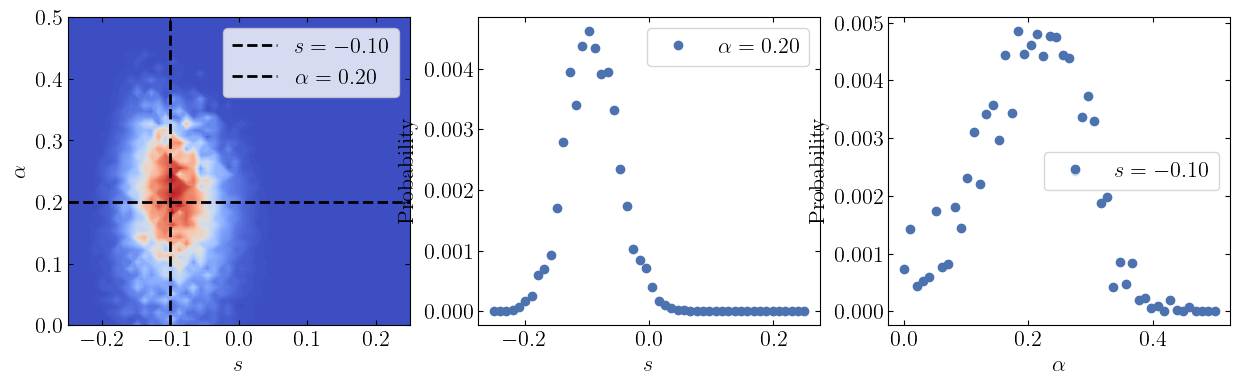

In [15]:
#plt.scatter(S, A,c = D.reshape(int(np.sqrt(len(D))),int(np.sqrt(len(D)))),cmap='coolwarm')

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))

ax1.contourf(S,A,P, levels=100, cmap='coolwarm')
ax1.vlines(t_obs[1], -0.0, 0.5, color='black', lw=2, ls='--',label=f'$s = {t_obs[1]:.2f}$')
ax1.hlines(t_obs[0], -0.25, 0.25, color='black', lw=2, ls='--',label=f'$\\alpha = {t_obs[0]:.2f}$')
ax1.set_xlabel('$s$')
ax1.set_ylabel('$\\alpha$')
ax1.legend()

ind_S = 20
ind_A = 15
ax2.plot(S[:,ind_S],P[:,ind_S],'o',label=f'$\\alpha = {A[0,ind_S]:.2f}$')
ax2.set_xlabel('$s$')
ax3.plot(A[ind_A,:],P[ind_A,:],'o',label=f'$s= {S[ind_A,0]:.2f}$')
ax3.set_xlabel('$\\alpha$')
print(f'Observed parameters: alpha = {t_obs[0]}, s = {t_obs[1]}')
#plt.vlines(t_obs[0], 0, np.max(P), color='red', lw=2, ls='--',label=f'$s = {t_obs[1]:.2f}$')

ax2.set_ylabel('Probability')
ax3.set_ylabel('Probability')
ax2.legend()
ax3.legend()

## Neural Network

In [16]:
data = np.load('train_data_1.npy')
target = np.load('target_data_1.npy')

In [17]:
fraction_train = 0.70; fraction_test = 0.10; fraction_valid = 1. - fraction_train - fraction_test

data_train = data[:int(fraction_train*len(data))]
target_train = target[:int(fraction_train*len(target))]

data_test = data[int(fraction_train*len(data)):int((fraction_train+fraction_test)*len(data))+1]
target_test = target[int(fraction_train*len(data)):int((fraction_train+fraction_test)*len(target))+1]

data_valid = data[1+int((fraction_train+fraction_test)*len(data)):]
target_valid = target[1+int((fraction_train+fraction_test)*len(target)):]

print(f"Training and target data size: {len(data_train)} x {len(target_train)} ")
print(f"Testing and target data size: {len(data_test)} x {len(target_test)} ")
print(f"Validation and target data size: {len(data_valid)} x {len(target_valid)} ")

Training and target data size: 35000 x 35000 
Testing and target data size: 5001 x 5001 
Validation and target data size: 9999 x 9999 


In [18]:
model = keras.models.Sequential([   
    keras.layers.InputLayer(shape=(32,)),
    keras.layers.Dense(64, activation='tanh'),
    keras.layers.Dense(32, activation='tanh'),
    keras.layers.Dense(2,activation='tanh')
])

In [19]:
model.compile(
  optimizer='adam',
  loss='mse',metrics=['accuracy'])

In [20]:
epochs = 150     ## Number of epoch to run
batch_size = 32  ## Mini batch size

# Train the model.
history = model.fit(
  data_train, target_train,
  epochs=epochs,
  batch_size=batch_size,
  verbose = 0,
  validation_data=(data_valid, target_valid))

KeyboardInterrupt: 

In [ ]:
predictions = model.predict(data_test)

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 400us/step


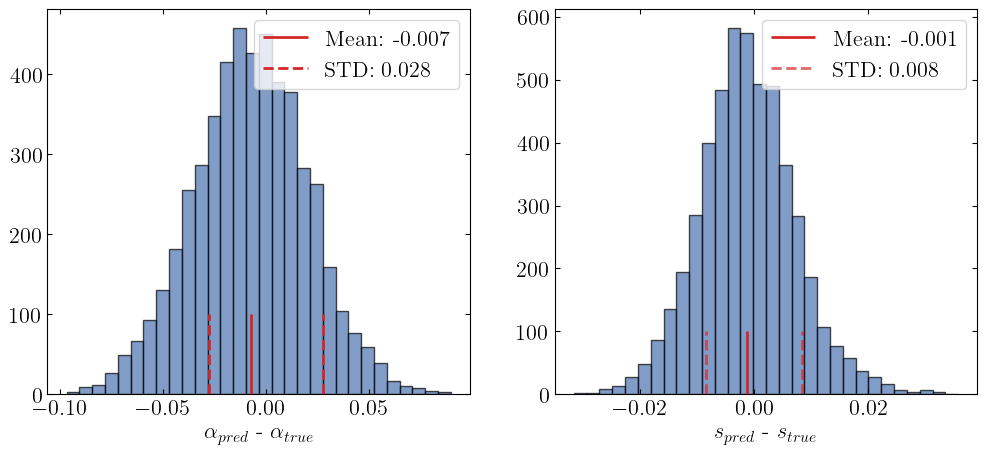

In [ ]:
dif = predictions[:,0] - target_test[:,0]
dif1 = predictions[:,1] - target_test[:,1]

fig, ax = plt.subplots(1,2,figsize=(12, 5))
ax[0].hist(predictions[:,0] - target_test[:,0],bins = 30 ,edgecolor='black', alpha=0.7)
ax[0].vlines(np.mean(dif), ymin=0, ymax=100, color='tab:red', lw=2, ls='-', label = f'Mean: {np.mean(dif):.3f}')
ax[0].vlines(np.std(dif), ymin=0, ymax=100, color='tab:red', lw=2, ls='--', label = f'STD: {np.std(dif):.3f}')
ax[0].vlines(-np.std(dif), ymin=0, ymax=100, color='tab:red', lw=2, ls='--')
ax[0].set_xlabel('$\\alpha_{pred}$ - $\\alpha_{true}$')


ax[1].hist(predictions[:,1] - target_test[:,1],bins = 30,edgecolor='black', alpha=0.7)
ax[1].vlines(np.mean(predictions[:,1] - target_test[:,1]), ymin=0, ymax=100, color='tab:red', lw=2, ls='-', label = f'Mean: {np.mean(predictions[:,1] - target_test[:,1]):.3f}')
ax[1].vlines(np.std(predictions[:,1] - target_test[:,1]), ymin=0, ymax=100, color='tab:red', lw=2, ls='--',alpha=0.7, label = f'STD: {np.std(predictions[:,1] - target_test[:,1]):.3f}')
ax[1].vlines(-np.std(predictions[:,1] - target_test[:,1]), ymin=0, ymax=100, color='tab:red', lw=2, ls='--',alpha=0.7)
ax[1].set_xlabel('$s_{pred}$ - $s_{true}$')
ax[0].legend()
ax[1].legend()

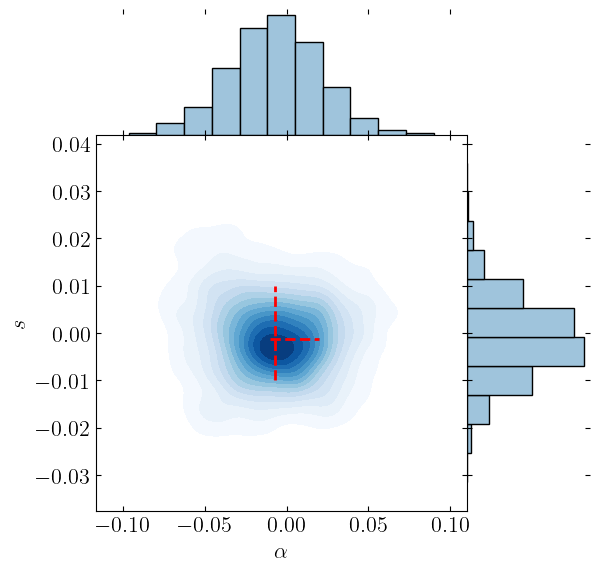

In [ ]:

data = pd.DataFrame(np.vstack((dif,dif1)).T,columns=[r"$\alpha$",r'$s$'])
x = r'$\alpha$'; y = '$s$'
#sns.jointplot(data = data, x =x,y =y,ratio=3,space = 0,kind = 'kde',fill = True,cmap='Blues', levels = 15)#,joint_kws={'fill':True,'cmap':'Blues','levels':15})
g = sns.jointplot(data = data, x =x,y =y,ratio=3,space = 0,kind = 'hist')#,joint_kws={'fill':True,'cmap':'Blues','levels':15})
for coll in list(g.ax_joint.collections):
    coll.remove()
g.plot_joint(sns.kdeplot,fill = True, cmap='Blues', levels = 15)
g.plot_marginals(sns.histplot, bins=11, color="#9FC4DC", alpha=1)

plt.vlines(np.mean(dif), -0.01, 0.01, color='red', lw=2, ls='--')
plt.hlines(np.mean(dif1), -0.01, 0.02, color='red', lw=2, ls='--')
#plt.vlines(0.5, -0.25, 0.25, color='red', lw=2, ls='--')
#plt.hlines(-0.25, 0, 0.5, color='red', lw=2, ls='--')
#plt.hlines(0.25, 0, 0.5, color='red', lw=2, ls='--')
plt.show()

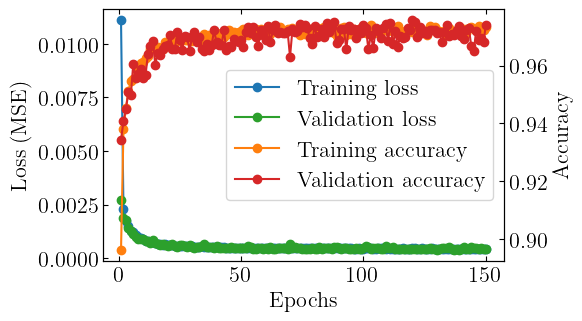

In [ ]:
epochrange = range(1, epochs + 1)

train_loss = history.history['loss']
val_loss = history.history['val_loss']

accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

fig, ax = plt.subplots(figsize=(6, 3.5))

ax1 = ax.twinx()
l1, = ax.plot(epochrange, train_loss, '-o',color = 'tab:blue', label='Training loss')
l2, = ax.plot(epochrange, val_loss, '-o',color = 'tab:green', label='Validation loss')
l3, = ax1.plot(epochrange, accuracy, '-o',color = 'tab:orange', label='Training accuracy')
l4, = ax1.plot(epochrange, val_accuracy, '-o',color = 'tab:red', label='Validation accuracy')


ax.set_xlabel('Epochs')
ax.set_ylabel('Loss (MSE)')   
ax1.set_ylabel('Accuracy')   
lines = [l1, l2, l3, l4]
labels = [l.get_label() for l in lines]
ax.legend(lines, labels, loc='center right')
plt.tight_layout()
plt.savefig('figs/training_validation_curve.pdf')

## ABC NN


In [ ]:
def colonel_NN(y_obs, model, N=100, h=1, mode = 'both'):
    sq = []
    D = []
    a = np.random.uniform(0,0.5,int(N))

    noise = np.random.normal(-0.003, 0.009, int(N))   # From previous prediction errors
    S = model.predict(np.array([y_obs]))[0,1] + noise

    for i in trange((N)):
        if mode == 'mean':
            diff = statistic(simulator(alpha = a[i], s = S[i]).ravel())[0] - statistic(y_obs.ravel())[0]
        elif mode == 'std':   
            diff = statistic(simulator(alpha = a[i], s = S[i]).ravel())[1] - statistic(y_obs.ravel())[1]
        elif mode == 'both':
            diff_mean, diff_std= np.array(statistic(simulator(alpha = a[i], s = S[i]).ravel())) - np.array(statistic(y_obs.ravel()))
            diff = np.sqrt(diff_mean**2 + diff_std**2)
        else:
            raise ValueError("Mode must be 'mean', 'std', or 'both'")
        sq.append(diff**2 / h)
        D.append(diff)
    SQ = np.array(sq)
    D = np.array(D)
    return (D), (np.exp(-0.5 * (SQ)) / np.sum(np.exp(-0.5 * (SQ)))), (a), (S)

In [ ]:
t_obs = np.array([0.3, 0.2])
y_obs = simulator(alpha=t_obs[0], s=t_obs[1], N=int(1e3))

d, p, a, s = colonel_NN(y_obs, model, N=500, h=0.1, mode = 'mean')   # Difference in summary statistics  # Kernel size / Probability

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


100%|██████████| 500/500 [00:00<00:00, 986.74it/s] 


Observed parameters: alpha = 0.3, s = 0.2


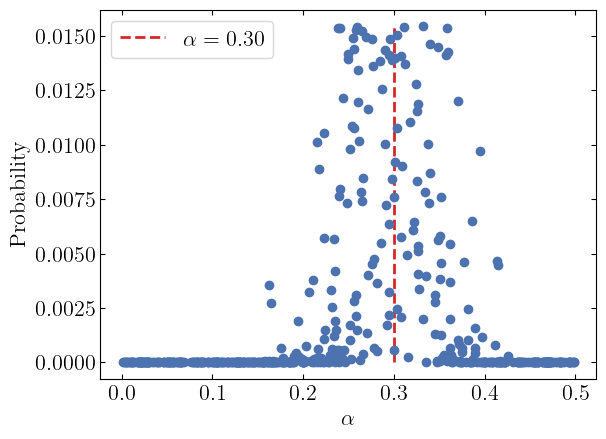

In [ ]:
print(f'Observed parameters: alpha = {t_obs[0]}, s = {t_obs[1]}')

plt.vlines(t_obs[0], 0, np.max(p), color='tab:red', lw=2, ls='--', label=f'$\\alpha = {t_obs[0]:.2f}$')
plt.plot(a,p,'o')
plt.xlabel('$\\alpha$')
plt.ylabel('Probability')
plt.legend()


In [26]:
def weighted_quantile(x, w, q):
    x = np.asarray(x, dtype=float)
    w = np.asarray(w, dtype=float)
    w = w / np.sum(w)

    idx = np.argsort(x)
    x_sorted = x[idx]
    w_sorted = w[idx]

    cdf = np.cumsum(w_sorted)
    return np.interp(q, cdf, x_sorted)

def weighted_ci(x, w, conf_level=0.95):
    alpha = 1.0 - conf_level
    lo = weighted_quantile(x, w, alpha/2)
    hi = weighted_quantile(x, w, 1 - alpha/2)
    return lo, hi

def weighted_mean_std(x, w):
    w = np.asarray(w)
    w = w / np.sum(w)
    mu = np.sum(w * x)
    var = np.sum(w * (x - mu)**2)
    return mu, np.sqrt(var)

Observed parameters: alpha = 0.3, s = 0.2


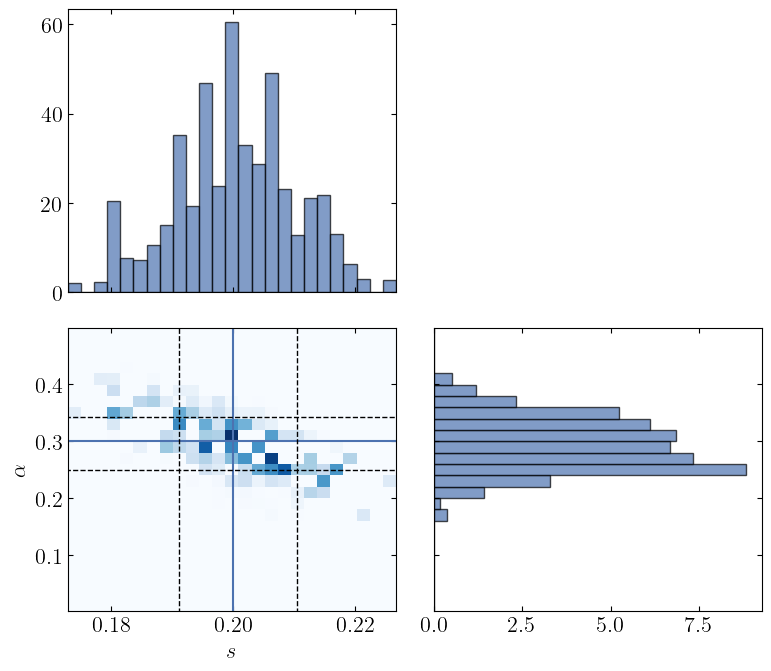

In [ ]:
fig, ax = plt.subplots(2,2,figsize=(8,7), sharex='col', sharey='row')

ax[0,1].axis('off')

ax[0,0].hist(s,bins=25,weights=p,edgecolor='black', alpha=0.7,density=True,orientation='vertical')
ax[1,1].hist(a,bins=25,weights=p,edgecolor='black', alpha=0.7,density=True,orientation='horizontal')
ax[1,0].axhline(t_obs[0])
ax[1,0].axvline(t_obs[1])

print(f'Observed parameters: alpha = {t_obs[0]}, s = {t_obs[1]}')

ax[1,0].hist2d(s,a,bins=25, weights=p, cmap='Blues')
ax[1,0].set_xlabel('$s$')
ax[1,0].set_ylabel('$\\alpha$')

s_lo, s_hi = weighted_ci(s, p, 0.68)
a_lo, a_hi = weighted_ci(a, p, 0.68)

ax[1,0].vlines(s_lo, -0.5, 0.5, color='black', lw=1, ls='--')
ax[1,0].vlines(s_hi, -0.5, 0.5, color='black', lw=1, ls='--')
ax[1,0].hlines(a_lo, -0.25, 0.25, color='black', lw=1, ls='--')
ax[1,0].hlines(a_hi, -0.25, 0.25, color='black', lw=1, ls='--')
plt.tight_layout()

## ABC Chain

In [22]:
def colonel_chain(y_obs, N_chain=5, N=100, h=1, mode = 'mean'):
    for j in range(N_chain):
        sq = []
        D = []

        if j == 0:
            a = np.random.uniform(0,0.5,int(N))
            s = np.random.uniform(-0.25,0.25,int(N))
        else:
            a_mu, a_std = weighted_mean_std(a, P)
            s_mu, s_std = weighted_mean_std(s, P)


            s = np.sort(scipy.stats.norm.rvs(loc= s_mu, scale = s_std, size = int(N)))
            a = np.sort(scipy.stats.norm.rvs(loc= a_mu, scale = a_std, size = int(N)))

            print(f'Chain {j}: a_mu = {a_mu}, a_std = {a_std}, s_mu = {s_mu}, s_std = {s_std}')

        for i in range((N)):
            y_sim = simulator(alpha = a[i], s = s[i]).ravel()

            if mode == 'mean':
                diff = statistic(y_sim)[0] - statistic(y_obs.ravel())[0]
            elif mode == 'std':   
                diff = statistic(y_sim)[1] - statistic(y_obs.ravel())[1]
            elif mode == 'both':
                diff_mean, diff_std= np.array(statistic(y_sim)) - np.array(statistic(y_obs.ravel()))
                diff = np.sqrt(diff_mean**2 + diff_std**2)
            else:
                raise ValueError("Mode must be 'mean', 'std', or 'both'")
            
            sq.append(diff**2 / h)
            D.append(diff)

        SQ = np.array(sq)
        P = np.exp(-0.5 * (SQ)) / np.sum(np.exp(-0.5 * (SQ)))

    return np.array(D), P, a, s

In [50]:
t_obs = np.array([0.1, -0.1])    # alpha, s
y_obs = simulator(alpha=t_obs[0], s=t_obs[1], N=int(1e3))

D_chain, P_chain, a_chain, s_chain = colonel_chain(y_obs, N_chain=1, N=1000, h=0.01, mode = 'mean')

Observed parameters: alpha = 0.0, s = 0.2


/var/folders/cc/g7htxfj57sq65d7g1185yzwr0000gn/T/ipykernel_35828/57843421.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax1.legend()


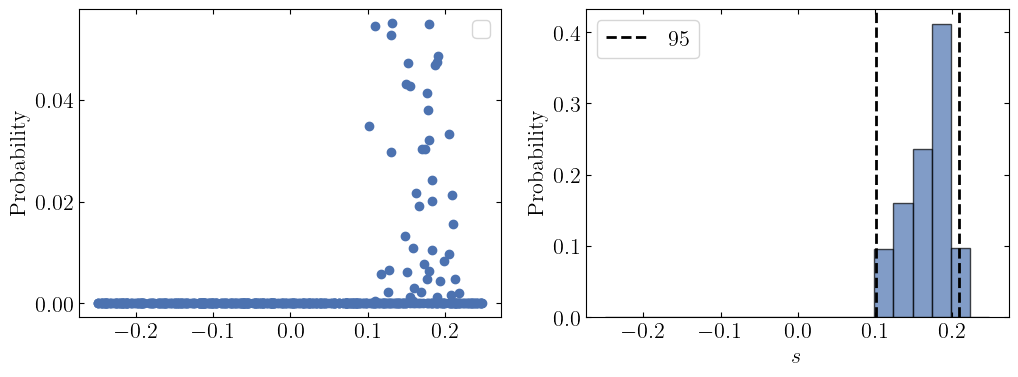

In [ ]:
print(f'Observed parameters: alpha = {t_obs[0]}, s = {t_obs[1]}')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
# ax1.vlines(t_obs[0], 0, np.max(P_chain), color='tab:red', lw=2, ls='--', label=f'$\\alpha = {t_obs[0]:.2f}$')
ax1.plot(s_chain,P_chain,'o')

ax1.set_ylabel('Probability')
ax1.legend()

ax2.hist(s_chain, weights=P_chain, bins=20, edgecolor='black', alpha=0.7)
ax2.set_xlabel('$s$')
ax2.set_ylabel('Probability')


s_lo, s_hi = weighted_ci(s_chain, P_chain, 0.95)
a_lo, a_hi = weighted_ci(a_chain, P_chain, 0.95)
ax2.axvline(s_lo, color='k', ls='--', lw=2, label='95% CI')
ax2.axvline(s_hi, color='k', ls='--', lw=2)
ax2.legend()

Observed parameters: alpha = 0.1, s = -0.1


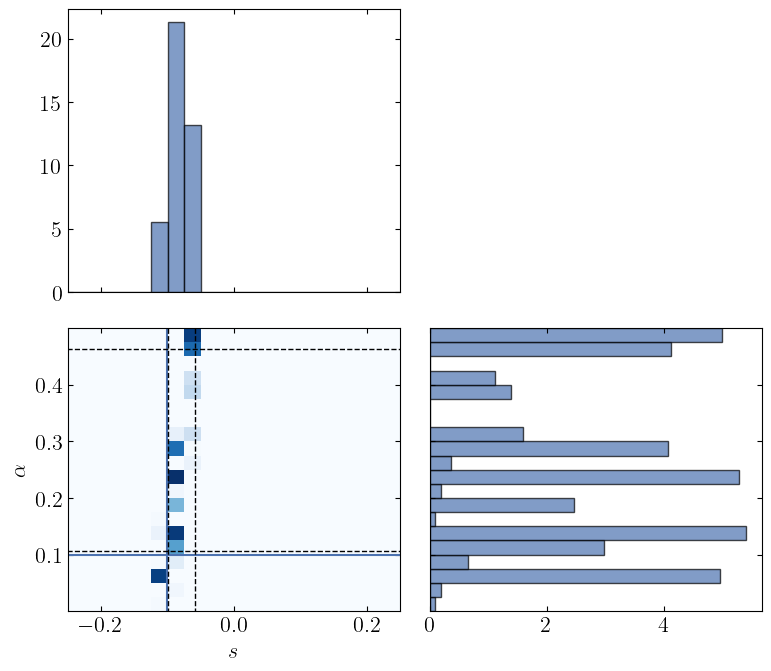

In [51]:
fig, ax = plt.subplots(2,2,figsize=(8,7),sharex='col', sharey='row')

ax[0,1].axis('off')
bins = 20
ax[0,0].hist(s_chain,bins=bins,weights=P_chain, edgecolor='black', alpha=0.7,density=True,orientation='vertical')
ax[1,1].hist(a_chain,bins=bins,weights=P_chain,edgecolor='black', alpha=0.7,density=True,orientation='horizontal')
ax[1,0].axhline(t_obs[0])
ax[1,0].axvline(t_obs[1])

print(f'Observed parameters: alpha = {t_obs[0]}, s = {t_obs[1]}')

ax[1,0].hist2d(s_chain,a_chain,bins=bins, weights=P_chain, cmap='Blues')
ax[1,0].set_xlabel('$s$')
ax[1,0].set_ylabel('$\\alpha$')

s_lo, s_hi = weighted_ci(s_chain, P_chain, 0.68)
a_lo, a_hi = weighted_ci(a_chain, P_chain, 0.68)

ax[1,0].vlines(s_lo, -0.5, 0.5, color='black', lw=1, ls='--')
ax[1,0].vlines(s_hi, -0.5, 0.5, color='black', lw=1, ls='--')
ax[1,0].hlines(a_lo, -0.25, 0.25, color='black', lw=1, ls='--')
ax[1,0].hlines(a_hi, -0.25, 0.25, color='black', lw=1, ls='--')
plt.tight_layout()

## ABC chain with NN on exp data

In [52]:
def s_predictor(Y_obs, model):
    N = Y_obs.shape[0]
    s_pred = np.zeros(N)
    a_pred = np.zeros(N)
    for i in range(N):
        y_obs = Y_obs[i,:].ravel()
        a, s = model.predict(y_obs[None, :].astype("float32"), verbose=0)[0]
        s_pred[i] = s
        a_pred[i] = a
    return s_pred, a_pred

In [53]:
def colonel_chain_nn(Y_obs, N_chain=5, N=100, h=1, mode = 'mean', model = model):
    history = {'a_mu':[], 'a_std':[]}
    
    noise = scipy.stats.norm.rvs(-0.003, 0.009, int(N_chain))   # From previous prediction errors
    S, A = s_predictor(Y_obs[:N_chain], model) + noise # (N_chain,)

    for j in trange(N_chain):
        sq = []
        D = []
        y_obs = Y_obs[j,:].ravel()
        mu_obs, std_obs = statistic(y_obs)

        if j == 0:
            a = np.random.uniform(0,0.5,int(N))
        else:
            a_mu, a_std = weighted_mean_std(a, P)
            # print(f'Chain {j}: a_mu = {a_mu}, a_std = {a_std}')
            a = np.sort(scipy.stats.norm.rvs(loc= a_mu, scale = a_std, size = int(N)))

        s_chain = np.full(int(N), S[j], dtype=float)

        for i in range((N)):

            y_sim = simulator(alpha = a[i], s = S[j]).ravel()

            if mode == 'mean':
                diff = statistic(y_sim)[0] - mu_obs
            elif mode == 'std':   
                diff = statistic(y_sim)[1] - std_obs
            elif mode == 'both':
                diff_mean, diff_std= np.array(statistic(y_sim)) - np.array([mu_obs, std_obs])
                diff = np.sqrt(diff_mean**2 + diff_std**2)
            else:
                raise ValueError("Mode must be 'mean', 'std', or 'both'")
            
            sq.append(diff**2 / h)
            D.append(diff)

        SQ = np.array(sq)
        P = np.exp(-0.5 * (SQ)) / np.sum(np.exp(-0.5 * (SQ)))

        a_mean, a_stand = weighted_mean_std(a, P)

        history['a_mu'].append(a_mean)
        history['a_std'].append(a_stand)


    return np.array(D), P, a, s_chain, A, S, history

In [54]:
Y_obs = np.load('board_data.npy')

D_chain_nn, P_chain_nn, a_chain_nn, s_chain_nn, A, S, history_chain = colonel_chain_nn(Y_obs, N_chain=250, N=1000, h=0.25, mode = 'mean')

  7%|▋         | 17/250 [00:16<03:51,  1.01it/s]


KeyboardInterrupt: 

In [55]:

fig = plt.figure(figsize=(6,4))
plt.plot(history_chain['a_mu'][3:], label='Mean of $\\alpha$', lw=3, color='tab:blue')
plt.plot(A[3:], 'o', color='tab:red', label='NN prediction of $\\alpha$', alpha=0.3)
plt.fill_between(range(len(history_chain['a_std'][3:])),
                 np.array(history_chain['a_mu'][3:]) - np.array(history_chain['a_std'][3:]),
                 np.array(history_chain['a_mu'][3:]) + np.array(history_chain['a_std'][3:]),
                 color='tab:blue', alpha=0.5, label='$\\pm \\sigma_{\\alpha}$ ')
plt.xlabel('Chain iteration')
plt.ylabel('$\\alpha$')
plt.legend()
plt.savefig('figs/chain_convergence_200_1000_01_mean.pdf', bbox_inches='tight')

print(f'Final estimate of alpha: {history_chain["a_mu"][-1]} +/- {history_chain["a_std"][-1]}')

NameError: name 'history_chain' is not defined

<Figure size 600x400 with 0 Axes>

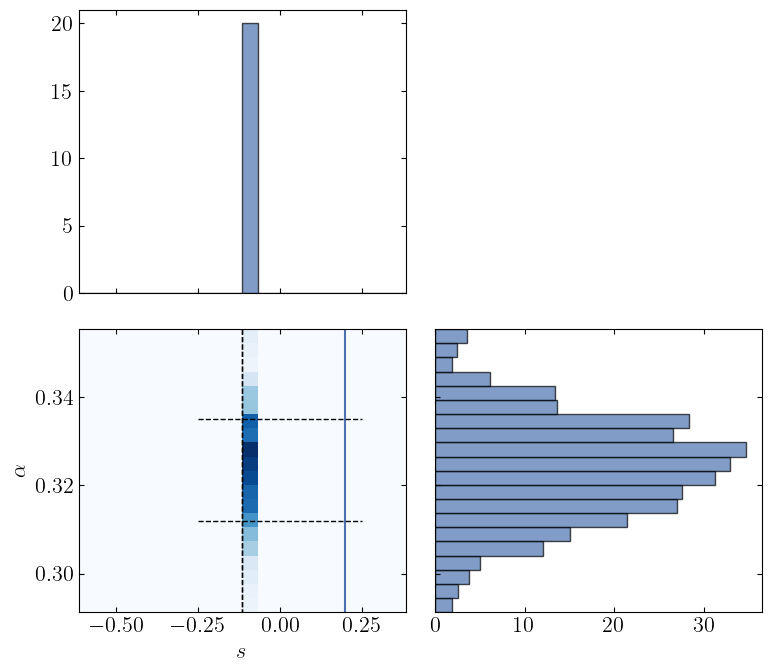

In [ ]:
fig, ax = plt.subplots(2,2,figsize=(8,7),sharex='col', sharey='row')

ax[0,1].axis('off')
bins = 20
ax[0,0].hist(s_chain_nn,bins=bins, weights=P_chain_nn, edgecolor='black', alpha=0.7,density=True,orientation='vertical')
ax[1,1].hist(a_chain_nn,bins=bins,weights=P_chain_nn,edgecolor='black', alpha=0.7,density=True,orientation='horizontal')
ax[1,0].axhline(t_obs[0])
ax[1,0].axvline(t_obs[1])

ax[1,0].hist2d(s_chain_nn,a_chain_nn,bins=bins, weights=P_chain_nn, cmap='Blues')
ax[1,0].set_xlabel('$s$')
ax[1,0].set_ylabel('$\\alpha$')

s_lo, s_hi = weighted_ci(s_chain_nn, P_chain_nn, 0.68)
a_lo, a_hi = weighted_ci(a_chain_nn, P_chain_nn, 0.68)

ax[1,0].vlines(s_lo, -0.5, 0.5, color='black', lw=1, ls='--')
ax[1,0].vlines(s_hi, -0.5, 0.5, color='black', lw=1, ls='--')
ax[1,0].hlines(a_lo, -0.25, 0.25, color='black', lw=1, ls='--')
ax[1,0].hlines(a_hi, -0.25, 0.25, color='black', lw=1, ls='--')
plt.tight_layout()